In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from feature_collector import preprocess_data
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Wed Nov  6 22:43:43 2024


In [2]:
pricename = 'barrier_price'
data = df_collector.cboe_spx_barriers()

filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)
og_count = data.shape[0]
print('data collected')
data

data collected


,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price
0,4424.00000,3981.60000,2212.00000,60,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,519.00142
1,4424.00000,3981.60000,2212.00000,90,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,546.03043
2,4424.00000,3981.60000,2212.00000,90,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,44.88864
3,4424.00000,3981.60000,2212.00000,180,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,621.26178
4,4424.00000,3981.60000,2212.00000,180,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,63.62685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16064306,5813.50000,6394.85000,8720.25000,540,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,598.88951
16064307,5813.50000,6394.85000,8720.25000,540,Up,In,call,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,87.93904
16064308,5813.50000,6394.85000,8720.25000,720,Up,Out,call,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,377.39147
16064309,5813.50000,6394.85000,8720.25000,720,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,650.45980


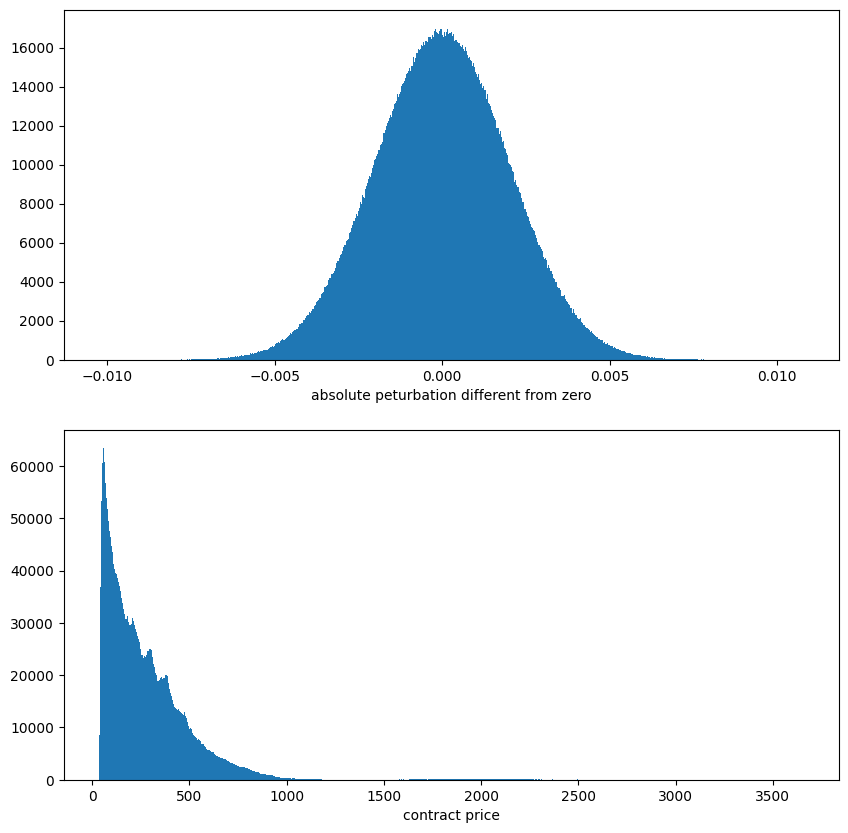

In [3]:
data['observed_price'] = data[pricename].apply(lambda x: max(x + np.random.normal(scale=0.002),0) if x > 0 else 0)
data = data[data['observed_price']>0]

p = data[pricename]-data['observed_price']
# p = p[p!=0]
plotprices = data['observed_price']
plotprices = plotprices[plotprices>0.01]

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5))
axs[0].set_xlabel('absolute peturbation different from zero')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5))
axs[1].set_xlabel('contract price')
plt.show()

In [4]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance variables:


{'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [5]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price,observed_price
0,4424.00000,3981.60000,2212.00000,60,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,519.00142,518.99705
1,4424.00000,3981.60000,2212.00000,90,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,546.03043,546.02713
2,4424.00000,3981.60000,2212.00000,90,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,44.88864,44.89397
3,4424.00000,3981.60000,2212.00000,180,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,621.26178,621.26042
4,4424.00000,3981.60000,2212.00000,180,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,63.62685,63.63253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16064306,5813.50000,6394.85000,8720.25000,540,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,598.88951,598.88645
16064307,5813.50000,6394.85000,8720.25000,540,Up,In,call,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,87.93904,87.94010
16064308,5813.50000,6394.85000,8720.25000,720,Up,Out,call,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,377.39147,377.38751
16064309,5813.50000,6394.85000,8720.25000,720,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,650.45980,650.46108


# preprocessing

In [6]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2022-01-26
1      2022-01-27
2      2022-01-28
3      2022-01-31
4      2022-02-01
          ...    
679    2024-10-09
680    2024-10-10
681    2024-10-11
682    2024-10-14
683    2024-10-15
Length: 684, dtype: object

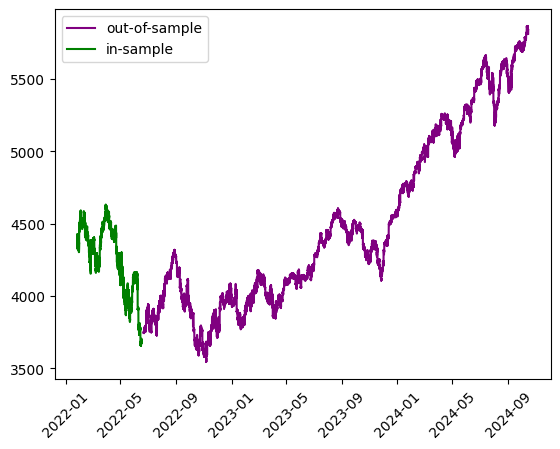

In [7]:
development_dates = dates[:100]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

# training

In [8]:
trainer.run_dnn()


training on 2648256 samples...

alpha: 0.01
hidden_layer_sizes: (14, 14)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 445.67278933525085


In [9]:
print('instance varianbles:')
trainer.__dict__

instance varianbles:


{'raw_data':           spot_price  strike_price    barrier  days_to_maturity updown outin  \
 0         4424.00000    3981.60000 2212.00000                60   Down   Out   
 1         4424.00000    3981.60000 2212.00000                90   Down   Out   
 2         4424.00000    3981.60000 2212.00000                90   Down   Out   
 3         4424.00000    3981.60000 2212.00000               180   Down   Out   
 4         4424.00000    3981.60000 2212.00000               180   Down   Out   
 ...              ...           ...        ...               ...    ...   ...   
 16064306  5813.50000    6394.85000 8720.25000               540     Up   Out   
 16064307  5813.50000    6394.85000 8720.25000               540     Up    In   
 16064308  5813.50000    6394.85000 8720.25000               720     Up   Out   
 16064309  5813.50000    6394.85000 8720.25000               720     Up   Out   
 16064310  5813.50000    6394.85000 8720.25000               720     Up    In   
 
              

In [10]:
trainer.model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'barrier',
                                                                                        'days_to_maturity',
                                                                                        'rebate',
                                                                                        'dividend_rate',
                                                                                        'risk_free_rate',
                                                                                        'theta',
                                                                                        'kappa',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['w',
                                                                                        'barrier_type_name'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(14,
                                                                                       14),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=StandardScaler())

### initial test

In [11]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 43.64612827574559
     MAE: 24.181458866319776

out of sample:
     RMSE: 85.39405651101832
     MAE: 53.35309603338795


# saving

In [12]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_06 225230737657 cboe spx barrier

cpu: 527.6125495433807
